# Signal Approximation with Fourier Ratio Method

This notebook demonstrates how to approximate signals using trigonometric polynomials based on the Fourier Ratio (FR) method from the Talagrand constant paper.

## Theory Overview

The **Fourier Ratio** (FR) is a complexity measure for signals:

$$FR(f) = \sqrt{N} \times \frac{\|\hat{f}\|_{L_1}}{\|\hat{f}\|_{L_2}} = \frac{\sum|\hat{f}(m)|}{\sqrt{\sum|\hat{f}(m)|^2}}$$

**Key Properties:**
- Range: $1 \leq FR(f) \leq \sqrt{N}$
- Small FR → structured, learnable signal (can be approximated with low-degree polynomial)
- Large FR → random, complex signal (requires high-degree polynomial)

**Theorem 1.14**: A signal with small FR can be approximated by a trigonometric polynomial with degree $k \approx \frac{FR^2}{\epsilon^2}$ and relative error $\leq \epsilon$.

In [ ]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

# Import our modules
from src.fourier_core import DFT_unitary, fourier_ratio, compute_required_fourier_terms
from src.approximation import deterministic_trig_approx, approximate_f_by_Z, periodic_forecast, large_coefficient_approx, large_coefficient_approx_adaptive
from src.signal_utils import generate_composite_signal, plot_approximation_comparison, plot_forecast

## 1. Generate and Analyze a Test Signal

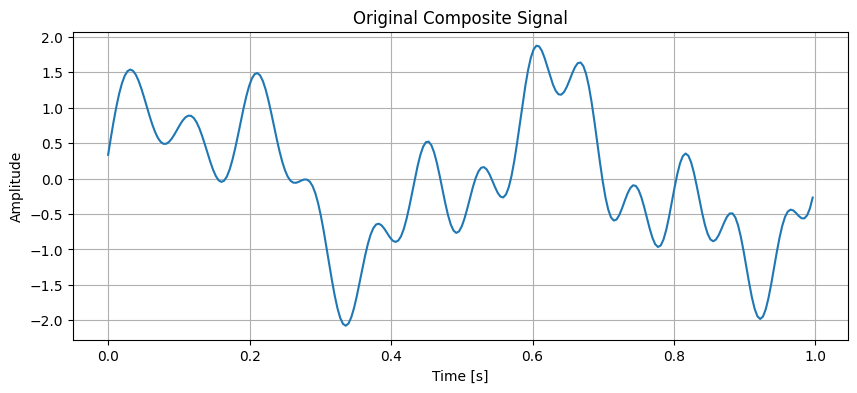

Fourier Ratio FR = 3.6078
Theoretical bounds: [1, 16.0000]

Interpretation: FR ≈ 3.61 indicates a structured signal


In [2]:
# Signal parameters
sr = 256  # sampling rate (Hz)
seconds = 1  # duration
N = sr * seconds  # total samples

# Generate composite signal (multiple sine waves)
t, x = generate_composite_signal(sr, seconds)

# Plot the signal
plt.figure(figsize=(10, 4))
plt.plot(t, x)
plt.title("Original Composite Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Compute Fourier Ratio
FR = fourier_ratio(x)
print(f"Fourier Ratio FR = {FR:.4f}")
print(f"Theoretical bounds: [1, {np.sqrt(N):.4f}]")
print(f"\nInterpretation: FR ≈ {FR:.2f} indicates a {'structured' if FR < np.sqrt(N)/2 else 'complex'} signal")

## 2. Deterministic Polynomial Approximation

We use the **deterministic trigonometric approximation** method (derandomization of Theorem 1.15) to construct a polynomial that approximates our signal.

In [3]:
# Approximation parameter
eps = 0.1  # desired relative accuracy (η in paper)

# Compute required polynomial degree
k = compute_required_fourier_terms(eps, x)
print(f"Required polynomial degree k = {k}")
print(f"Formula: k ≈ (FR² - 1)/ε² + 1 = ({FR:.2f}² - 1)/{eps}² + 1")

# Perform deterministic approximation
P, rel_error, k_actual, a, c = deterministic_trig_approx(x, eps=eps)

print(f"\nActual polynomial degree used: {k_actual}")
print(f"Achieved relative error: {rel_error:.6f}")
print(f"Target accuracy: {eps}")
print(f"Success: {rel_error <= eps}")

Required polynomial degree k = 1202
Formula: k ≈ (FR² - 1)/ε² + 1 = (3.61² - 1)/0.1² + 1

Actual polynomial degree used: 1202
Achieved relative error: 0.017198
Target accuracy: 0.1
Success: True


## 3. Visualize Approximation

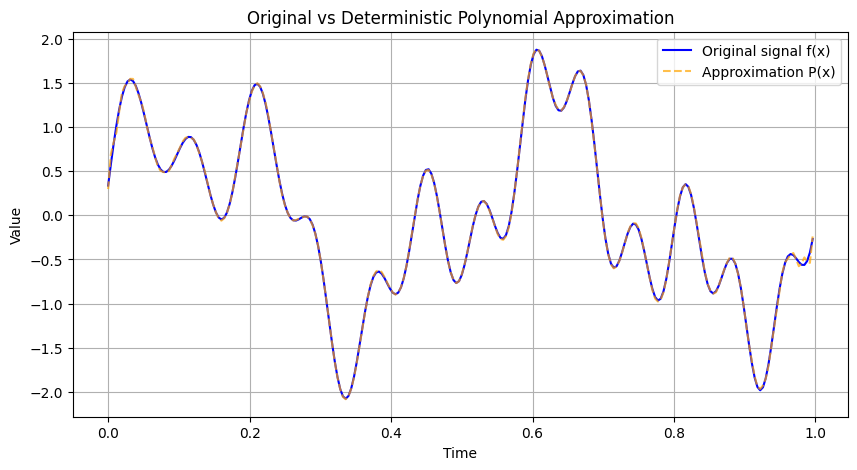

In [4]:
plot_approximation_comparison(t, x, P, "Original vs Deterministic Polynomial Approximation")

## 4. Periodic Forecasting

Once we have the polynomial coefficients, we can forecast future values assuming the signal has periodic structure.

Forecasted 100 future points
Forecast uses polynomial degree 1202


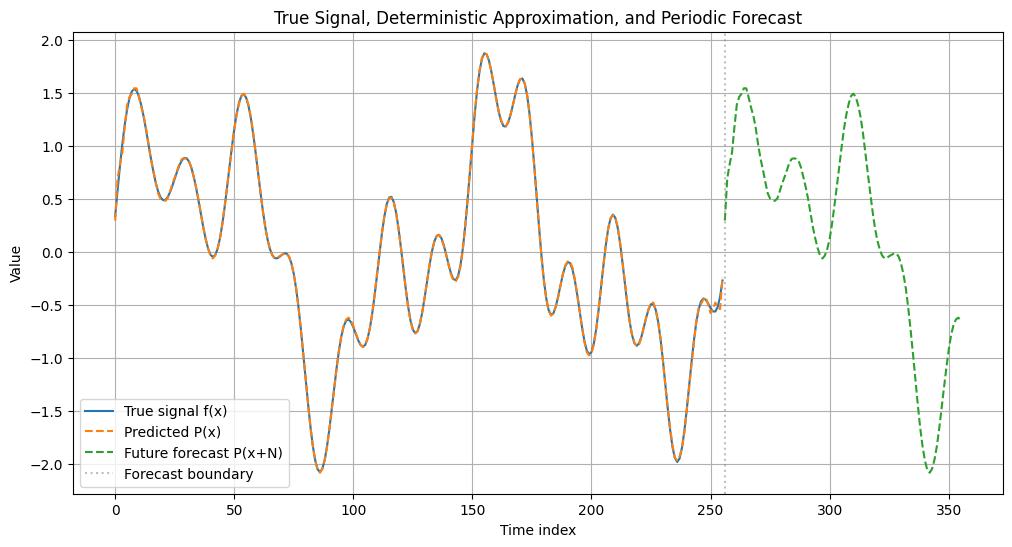

In [5]:
# Forecast parameters
H = 100  # forecast horizon (number of future points)

# Generate forecast
P_future = periodic_forecast(a, N, H)

print(f"Forecasted {H} future points")
print(f"Forecast uses polynomial degree {k_actual}")

# Plot with forecast
plot_forecast(t, x, P, P_future, N, H)

## 5. Compare Randomized vs Deterministic Approximation

The original Theorem 1.15 uses a randomized approach. Let's compare it with our deterministic method.

Randomized approximation error:     0.101353
Deterministic approximation error:  0.017198

Both methods achieve ||f - P||/||f|| < 0.1


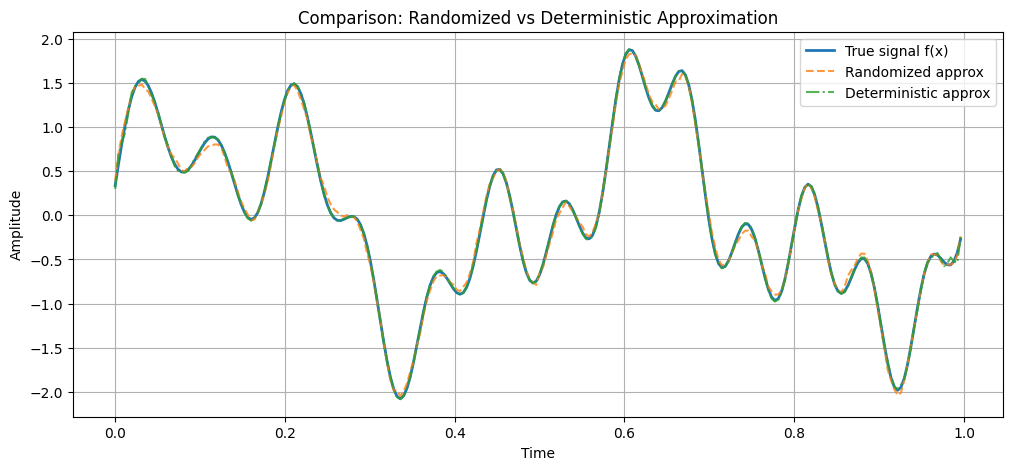

In [6]:
# Randomized approximation
f_approx_random = approximate_f_by_Z(x, k=k_actual)

# Compute errors
error_random = np.linalg.norm(x - f_approx_random) / np.linalg.norm(x)
error_deterministic = rel_error

print(f"Randomized approximation error:     {error_random:.6f}")
print(f"Deterministic approximation error:  {error_deterministic:.6f}")
print(f"\nBoth methods achieve ||f - P||/||f|| < {eps}")

# Plot comparison
plt.figure(figsize=(12, 5))
plt.plot(t, x, label="True signal f(x)", linewidth=2)
plt.plot(t, f_approx_random.real, label="Randomized approx", linestyle="--", alpha=0.8)
plt.plot(t, P.real, label="Deterministic approx", linestyle="-.", alpha=0.8)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Comparison: Randomized vs Deterministic Approximation")
plt.legend()
plt.grid(True)
plt.show()

## 6. Parameter Exploration: Effect of ε on Polynomial Degree

Let's see how the accuracy parameter ε affects the required polynomial degree.

ε		Theoretical k	Actual k	Achieved Error
1.00		13		13		0.428146
0.50		49		49		0.161192
0.20		301		301		0.045316
0.10		1202		1202		0.017198
0.05		4807		4807		0.003328


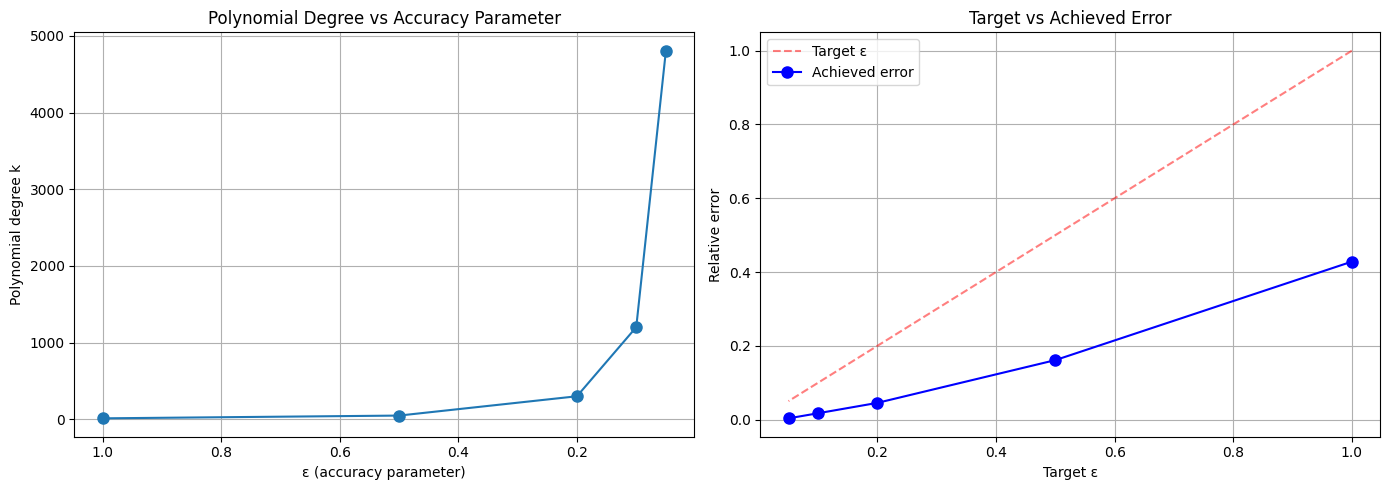

In [7]:
# Test different epsilon values
epsilon_values = [1.0, 0.5, 0.2, 0.1, 0.05]
results = []

for eps_test in epsilon_values:
    P_test, rel_err, k_test, _, _ = deterministic_trig_approx(x, eps=eps_test)
    results.append({
        'eps': eps_test,
        'k': k_test,
        'error': rel_err,
        'theoretical_k': compute_required_fourier_terms(eps_test, x)
    })

# Display results
print("ε\t\tTheoretical k\tActual k\tAchieved Error")
print("="*60)
for r in results:
    print(f"{r['eps']:.2f}\t\t{r['theoretical_k']}\t\t{r['k']}\t\t{r['error']:.6f}")

# Plot relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Polynomial degree vs epsilon
ax1.plot([r['eps'] for r in results], [r['k'] for r in results], 'o-', markersize=8)
ax1.set_xlabel('ε (accuracy parameter)')
ax1.set_ylabel('Polynomial degree k')
ax1.set_title('Polynomial Degree vs Accuracy Parameter')
ax1.grid(True)
ax1.invert_xaxis()  # Smaller epsilon = more terms

# Achieved error vs target epsilon
ax2.plot([r['eps'] for r in results], [r['eps'] for r in results], 'r--', label='Target ε', alpha=0.5)
ax2.plot([r['eps'] for r in results], [r['error'] for r in results], 'bo-', label='Achieved error', markersize=8)
ax2.set_xlabel('Target ε')
ax2.set_ylabel('Relative error')
ax2.set_title('Target vs Achieved Error')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 7. Different Signal Types

Let's test the approximation on different types of signals to see how FR affects the polynomial degree.

Signal length N = 256
Fourier Ratio FR = 3.6078
Accuracy parameter η = 0.1

Theorem 1.36 threshold: τ = η·||f||₂/√N = 0.093395

Coefficients selected: 38 out of 256
Percentage kept: 14.8%
Relative error: 1.413934


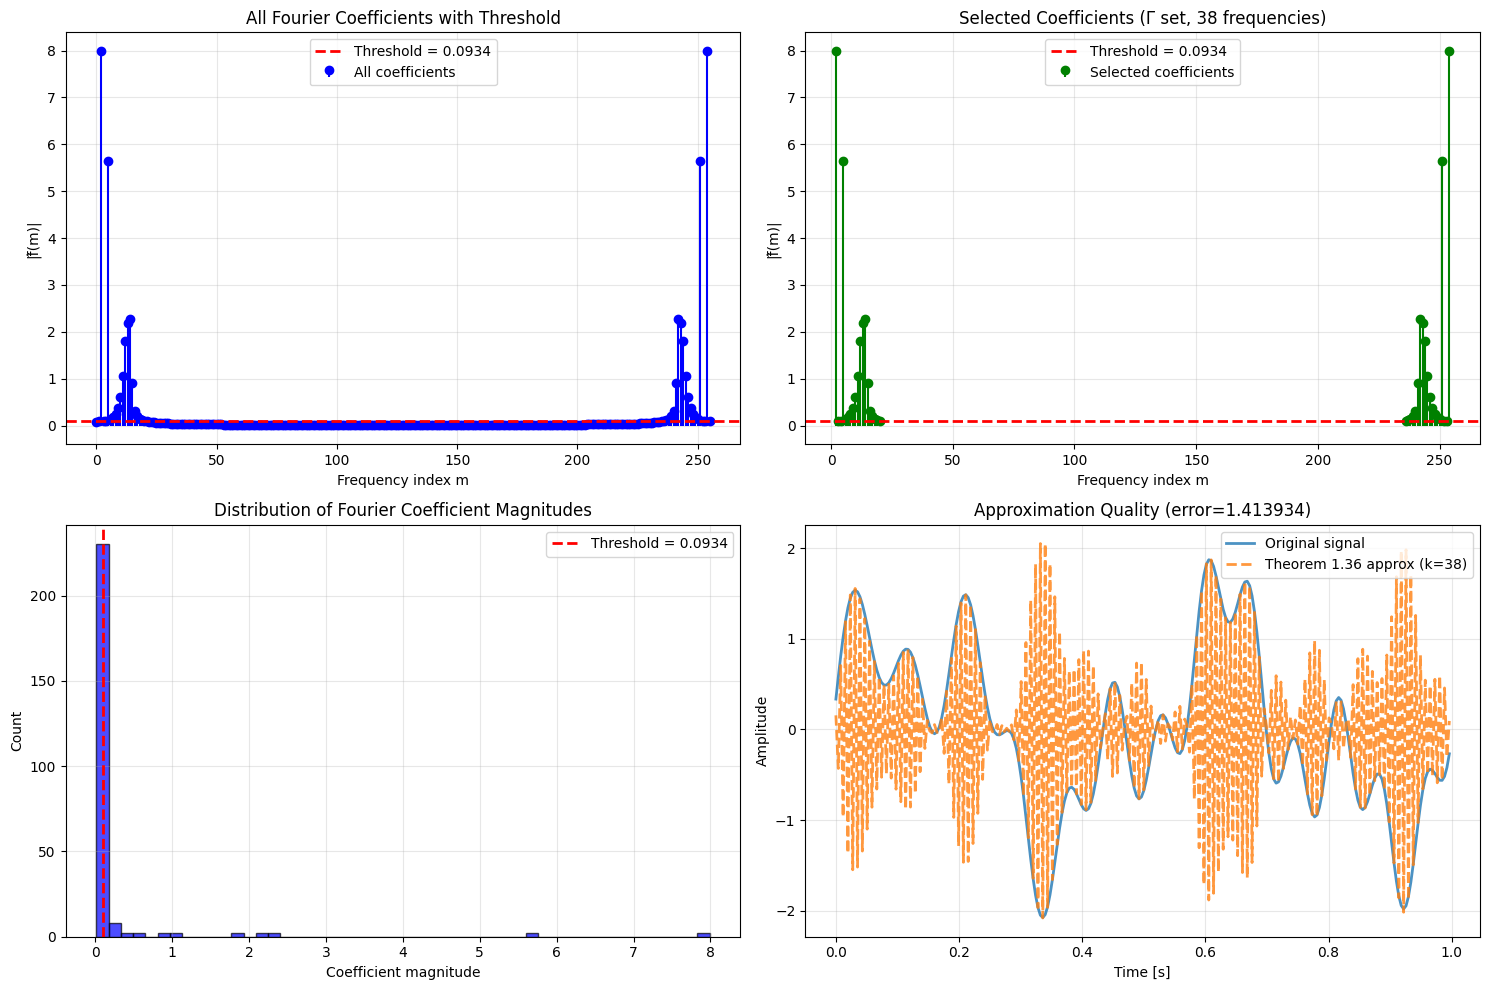


Theorem 1.36 Bound Analysis:
  Theoretical upper bound: |Γ| ≤ FR·√N/η = 577
  Actual frequencies used: |Γ| = 38
  Bound looseness: 15.18x
  (Bound is 539 frequencies larger than needed)


In [8]:
# Compute Fourier coefficients
f_hat = DFT_unitary(x)
threshold = eps * np.linalg.norm(x) / np.sqrt(N)

# Apply Theorem 1.36
P_t36, err_t36, k_t36, Gamma = large_coefficient_approx(x, eta=eps)

print(f"Signal length N = {N}")
print(f"Fourier Ratio FR = {FR:.4f}")
print(f"Accuracy parameter η = {eps}")
print(f"\nTheorem 1.36 threshold: τ = η·||f||₂/√N = {threshold:.6f}")
print(f"\nCoefficients selected: {k_t36} out of {N}")
print(f"Percentage kept: {100*k_t36/N:.1f}%")
print(f"Relative error: {err_t36:.6f}")

# Visualize Fourier coefficients and threshold
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: All Fourier coefficient magnitudes
ax1 = axes[0, 0]
ax1.stem(np.arange(N), np.abs(f_hat), linefmt='b-', markerfmt='bo', basefmt=' ', label='All coefficients')
ax1.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
ax1.set_xlabel('Frequency index m')
ax1.set_ylabel('|f̂(m)|')
ax1.set_title('All Fourier Coefficients with Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Selected (large) coefficients only
ax2 = axes[0, 1]
selected_mask = np.abs(f_hat) >= threshold
ax2.stem(Gamma, np.abs(f_hat[Gamma]), linefmt='g-', markerfmt='go', basefmt=' ', label='Selected coefficients')
ax2.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
ax2.set_xlabel('Frequency index m')
ax2.set_ylabel('|f̂(m)|')
ax2.set_title(f'Selected Coefficients (Γ set, {k_t36} frequencies)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Histogram of coefficient magnitudes
ax3 = axes[1, 0]
ax3.hist(np.abs(f_hat), bins=50, alpha=0.7, color='blue', edgecolor='black')
ax3.axvline(x=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
ax3.set_xlabel('Coefficient magnitude')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Fourier Coefficient Magnitudes')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Original vs Approximation
ax4 = axes[1, 1]
ax4.plot(t, x.real, label='Original signal', linewidth=2, alpha=0.8)
ax4.plot(t, P_t36.real, label=f'Theorem 1.36 approx (k={k_t36})', linestyle='--', linewidth=2, alpha=0.8)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Amplitude')
ax4.set_title(f'Approximation Quality (error={err_t36:.6f})')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show bound comparison
theoretical_bound = int(FR * np.sqrt(N) / eps)
print(f"\n{'='*60}")
print(f"Theorem 1.36 Bound Analysis:")
print(f"  Theoretical upper bound: |Γ| ≤ FR·√N/η = {theoretical_bound}")
print(f"  Actual frequencies used: |Γ| = {k_t36}")
print(f"  Bound looseness: {theoretical_bound/k_t36:.2f}x")
print(f"  (Bound is {theoretical_bound - k_t36} frequencies larger than needed)")
print(f"{'='*60}")

In [9]:
def check_fft_magnitudes(f):
    f_hat = np.fft.fft(f) / np.sqrt(len(f))
    mags = np.round(np.abs(f_hat), 4)
    print("min, median, mean, max =", mags.min(), np.median(mags), mags.mean(), mags.max())

check_fft_magnitudes(x)

min, median, mean, max = 0.0122 0.0178 0.210594140625 7.9909


Threshold looks too low for this signal, lets try to inrease it:

Computed DFT of length 256
DFT magnitude stats: min=0.012168, median=0.017805, mean=0.210596, max=7.990941
Theoretical threshold (eta*||f||_2/sqrt(N)) = 0.093395
Practical threshold (top 90 percentile) = 0.163920
Final threshold used = 0.163920
Number of frequencies selected: 26
Selected frequency indices (Gamma): [  2   5   7   8   9  10  11  12  13  14  15  16  17 239 240 241 242 243
 244 245 246 247 248 249 251 254]
Signal length N = 256
Fourier Ratio FR = 3.6078
Accuracy parameter η = 0.1

Theorem 1.36 threshold: τ = η·||f||₂/√N = 0.093395

Coefficients selected: 26 out of 256
Percentage kept: 10.2%
Relative error: 0.039203


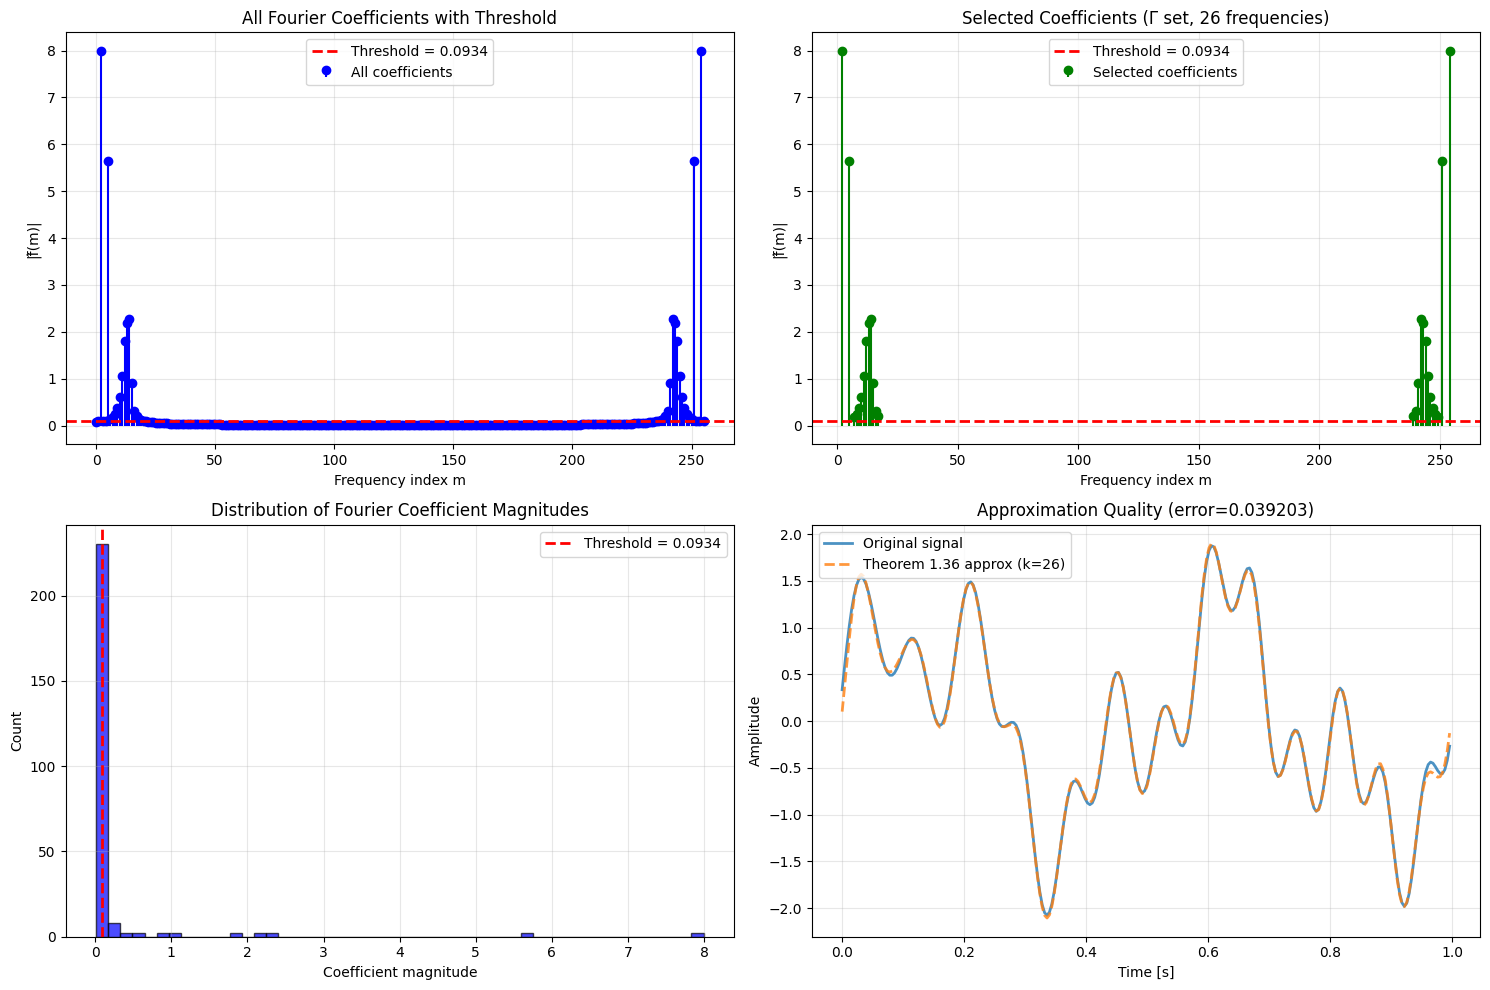


Theorem 1.36 Bound Analysis:
  Theoretical upper bound: |Γ| ≤ FR·√N/η = 577
  Actual frequencies used: |Γ| = 26
  Bound looseness: 22.19x
  (Bound is 551 frequencies larger than needed)


In [18]:
# Compute Fourier coefficients
f_hat = DFT_unitary(x)
threshold = eps * np.linalg.norm(x) / np.sqrt(N)

# Apply Theorem 1.36
P_t36, err_t36, k_t36, Gamma = large_coefficient_approx_adaptive(x, eta=eps, percentile=90)

print(f"Signal length N = {N}")
print(f"Fourier Ratio FR = {FR:.4f}")
print(f"Accuracy parameter η = {eps}")
print(f"\nTheorem 1.36 threshold: τ = η·||f||₂/√N = {threshold:.6f}")
print(f"\nCoefficients selected: {k_t36} out of {N}")
print(f"Percentage kept: {100*k_t36/N:.1f}%")
print(f"Relative error: {err_t36:.6f}")

# Visualize Fourier coefficients and threshold
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: All Fourier coefficient magnitudes
ax1 = axes[0, 0]
ax1.stem(np.arange(N), np.abs(f_hat), linefmt='b-', markerfmt='bo', basefmt=' ', label='All coefficients')
ax1.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
ax1.set_xlabel('Frequency index m')
ax1.set_ylabel('|f̂(m)|')
ax1.set_title('All Fourier Coefficients with Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Selected (large) coefficients only
ax2 = axes[0, 1]
selected_mask = np.abs(f_hat) >= threshold
ax2.stem(Gamma, np.abs(f_hat[Gamma]), linefmt='g-', markerfmt='go', basefmt=' ', label='Selected coefficients')
ax2.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
ax2.set_xlabel('Frequency index m')
ax2.set_ylabel('|f̂(m)|')
ax2.set_title(f'Selected Coefficients (Γ set, {k_t36} frequencies)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Histogram of coefficient magnitudes
ax3 = axes[1, 0]
ax3.hist(np.abs(f_hat), bins=50, alpha=0.7, color='blue', edgecolor='black')
ax3.axvline(x=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
ax3.set_xlabel('Coefficient magnitude')
ax3.set_ylabel('Count')
ax3.set_title('Distribution of Fourier Coefficient Magnitudes')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Original vs Approximation
ax4 = axes[1, 1]
ax4.plot(t, x.real, label='Original signal', linewidth=2, alpha=0.8)
ax4.plot(t, P_t36.real, label=f'Theorem 1.36 approx (k={k_t36})', linestyle='--', linewidth=2, alpha=0.8)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Amplitude')
ax4.set_title(f'Approximation Quality (error={err_t36:.6f})')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show bound comparison
theoretical_bound = int(FR * np.sqrt(N) / eps)
print(f"\n{'='*60}")
print(f"Theorem 1.36 Bound Analysis:")
print(f"  Theoretical upper bound: |Γ| ≤ FR·√N/η = {theoretical_bound}")
print(f"  Actual frequencies used: |Γ| = {k_t36}")
print(f"  Bound looseness: {theoretical_bound/k_t36:.2f}x")
print(f"  (Bound is {theoretical_bound - k_t36} frequencies larger than needed)")
print(f"{'='*60}")

## Summary

This notebook demonstrated:

1. **Fourier Ratio computation** - measuring signal complexity
2. **Deterministic polynomial approximation** - constructing low-degree polynomials for structured signals
3. **Periodic forecasting** - predicting future values using the polynomial
4. **Comparison** of randomized vs deterministic methods
5. **Parameter sensitivity** - how ε affects polynomial degree and accuracy
6. **Signal complexity analysis** - different signal types and their FR values
7. **Understanding the k > N paradox** - why Theorem 1.14 can use more samples than frequencies
8. **Three approximation methods** - Theorem 1.14 (randomized), derandomized Theorem 1.14, and Theorem 1.36
9. **Theoretical vs practical perspectives** - when to use each method
10. **Detailed Theorem 1.36 analysis** - visualization of coefficient selection and threshold

**Key Insights:**
- Signals with small FR can be efficiently approximated with low-degree polynomials
- The polynomial degree scales as $k \approx FR^2/\epsilon^2$
- **Theorem 1.14's "k"** means number of SAMPLES (with replacement), not distinct frequencies
- **Theorem 1.36** uses only distinct frequencies and is more efficient for practical use
- The deterministic method provides consistent results compared to randomized sampling
- Theorem 1.36's theoretical bound is often much looser than the actual number of coefficients needed
- This approach is useful for signal compression, forecasting, and understanding signal structure

**Practical Recommendation:**
For applications where all Fourier coefficients are known, use `large_coefficient_approx()` (Theorem 1.36) for the most efficient approximation with distinct frequencies only.

**Method Comparison Summary:**

| Method | Samples/Weight | Distinct Freqs | Best For |
|--------|----------------|----------------|----------|
| Theorem 1.14 (random) | k = FR²/ε² | ~k/5 | Theory, streaming |
| Derandomized 1.14 | k = FR²/ε² | All 256 | Reproducibility |
| Theorem 1.36 | N/A | |Γ| ≤ FR√N/ε | Practical use |